<h3>This notebook contains training code of a neural network performing the "Region of Interest" (ROI) detection work. Its output will be used at later stages to preprocess images being fed to the actual classifier. ROI NN will detect bounding boxes surrounding lesions and another algorithm will crop the images so that the aspect ratio required by InceptionResNetV2 NN is used.</h3>

In [1]:
import os
import absl.logging
import PIL.Image

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from typing import Callable
from tensorflow import keras

absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
get_names = lambda root_path: [
    file_name.split('.')[0]
    for dir_path, _, file_names in os.walk(root_path)
    for file_name in file_names
]
get_paths = lambda path: [f'{os.path.join(root, file)}' for root, dirs, files in os.walk(path) for file in files]
base_dir = os.path.join('..', 'data', 'images_original_inception_resnet_v2_200x150_splitted')
train_dir = os.path.join(base_dir, 'training')
valid_dir = os.path.join(base_dir, 'validation')

In [ ]:
def get_images_array(paths: list[str]) -> np.ndarray:
    rows = []
    rescale = keras.layers.Rescaling(1./255)

    for path in paths:
        with PIL.Image.open(path) as image:
            image_array = np.asarray(image)
            rescaled_image = rescale(image_array)
            rows.append(rescaled_image)

    return np.array(rows)


train_paths = get_paths(train_dir)
valid_paths = get_paths(valid_dir)
X_train = get_images_array(train_paths)
X_valid = get_images_array(valid_paths)

In [ ]:
SMALLER_WIDTH = 600 // 3
SMALLER_HEIGHT = 450 // 3

In [ ]:
train_names = set(get_names(train_dir))
valid_names = set(get_names(valid_dir))
metadata_path = os.path.join('..', 'data', 'HAM10000_metadata_ext.csv')
data = pd.read_csv(metadata_path).sort_values(by='image_id')
relevant_cols = ['top', 'left', 'bottom', 'right']
train_df = data[data['image_id'].isin(train_names)][relevant_cols]
valid_df = data[data['image_id'].isin(valid_names)][relevant_cols]
ys_train = train_df.to_numpy().astype(float)
ys_train[:, [0, 2]] /= SMALLER_HEIGHT
ys_train[:, [1, 3]] /= SMALLER_WIDTH
ys_valid = valid_df.to_numpy().astype(float)
ys_valid[:, [0, 2]] /= SMALLER_HEIGHT
ys_valid[:, [1, 3]] /= SMALLER_WIDTH

Using simple IoU loss made the model get stuck - it wasn't getting any better or worse. Using CIoU makes the model start from a worse starting point but it's learning. Let's see how it does after 1000 epochs.

Implementation idea: [Medium article](https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf)
*IoU formulas and more: [Researchgate article](https://www.researchgate.net/figure/CIoU-calculation-conceptualized-The-classification-function-L-cls-only-penalizes-if_fig5_355427005)

In [ ]:
def ciou_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Parameters:
    y_true -- ground truth bounding box, tensor of shape (?, 4), [xmin, ymin, xmax, ymax]
    y_pred -- predicted bounding box, tensor of shape (?, 4)

    Returns:
    ciou_loss -- scalar loss, tensor of shape ()
    """
    epsilon = 1e-3
    true_y1, true_x1, true_y2, true_x2 = tf.split(y_true, 4, axis = -1)
    pred_y1, pred_x1, pred_y2, pred_x2 = tf.split(y_pred, 4, axis = -1)
    # intersection calculation:
    # take leftmost x coord and rightmost x coord, subtract to get the width and constraint with
    # 0 to avoid negative values, do the same with ys
    intersect_w = tf.maximum(0.0, tf.minimum(true_x2, pred_x2) - tf.maximum(true_x1, pred_x1))
    intersect_h = tf.maximum(0.0, tf.minimum(true_y2, pred_y2) - tf.maximum(true_y1, pred_y1))
    # calculate area
    intersection = intersect_w * intersect_h
    # calculate areas of the predicted and actual bounding box
    # then calculate the union
    true_area = (true_x2 - true_x1) * (true_y2 - true_y1)
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    union = true_area + pred_area - intersection
    # IoU calculation
    iou = intersection / (union + epsilon)  # Adding epsilon to avoid division by zero
    # distance between the box centers
    true_center_x = (true_x1 + true_x2) / 2
    true_center_y = (true_y1 + true_y2) / 2
    pred_center_x = (pred_x1 + pred_x2) / 2
    pred_center_y = (pred_y1 + pred_y2) / 2
    # from pythagorean theorem - calculate euclidean distance a^2 + b^2 = c^2
    # here the distance is still in the square units, because it doesn't matter in this
    # context since if z1 < z2 then sqrt(z1) < sqrt(z2)
    # we can save some (very little) computation time by omitting the root calculation
    center_distance = tf.square(true_center_x - pred_center_x) + tf.square(true_center_y - pred_center_y)
    # enclosing box
    enclose_x1 = tf.minimum(true_x1, pred_x1)
    enclose_y1 = tf.minimum(true_y1, pred_y1)
    enclose_x2 = tf.maximum(true_x2, pred_x2)
    enclose_y2 = tf.maximum(true_y2, pred_y2)
    enclose_w = enclose_x2 - enclose_x1
    enclose_h = enclose_y2 - enclose_y1
    # CIoU term
    ciou_term = (1 - iou) + center_distance / (tf.square(enclose_w) + tf.square(enclose_h) + epsilon)

    return tf.reduce_mean(ciou_term)


def ciou_metric(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    ciou_term = ciou_loss(y_true, y_pred)

    return 1.0 - tf.reduce_mean(ciou_term) # higher value is better

The below architecture managed to achieve ~85% CIoU score, which is quite nice, but I strive for a higher number. Also, for the most parts it was getting stuck in a local minimum, either on -16% CIoU or 37% CIoU. I tried different weights initialization, lower and higher starting learning rates, different optimizers, adding and removing layers and nothing worked, so I switched to a different architecture. Also, the best models built with this architecture are saved and pushed to the git repo.

In [ ]:
def get_baseline_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_conv_module(prev: keras.layers.Layer, filters: int, kernel_size: int) -> keras.layers.Layer:
        x = keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(prev)
        x = keras.layers.Conv2D(filters * 2, kernel_size, padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D()(x)

        return x


    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv_module = get_conv_module(_input, 16, 7)
    conv_module = get_conv_module(conv_module, 32, 5)
    conv_module = get_conv_module(conv_module, 64, 3)
    conv_module = get_conv_module(conv_module, 128, 3)
    conv_module = get_conv_module(conv_module, 256, 3)
    conv_module = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(128, activation='relu')(conv_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
def run_model(model_factory, model_name: str, loss: Callable, metric: Callable):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_ciou_metric',
        mode='max',
        patience=20,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_ciou_metric',
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=5,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='models/' + model_name + '_{epoch}',
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=f'tensor_logs/{model_name}')
    model = model_factory(loss, metric)

    return model.fit(
        X_train,
        ys_train,
        validation_data=(X_valid, ys_valid),
        epochs=500,
        batch_size=64,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

Using a custom model yields CIoU accuracy on a ~80% level which is unsatisfactory. Let's try inception model next.

In [9]:
history = run_model(get_baseline_model, f'roi_detection_iou_8', ciou_loss, ciou_metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 200, 16)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 200, 32)      25120     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 100, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 100, 32)       25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 100, 64)       51264     
                                                             

INFO:tensorflow:Assets written to: models\roi_detection_iou_8_1\assets


126/126 [==============================] - 42s 253ms/step - loss: 0.5138 - ciou_metric: 0.4869 - val_loss: 0.4242 - val_ciou_metric: 0.5743 - lr: 0.0010
Epoch 2/500
126/126 [==============================] - ETA: 0s - loss: 0.3478 - ciou_metric: 0.6523INFO:tensorflow:Assets written to: models\roi_detection_iou_8_2\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_2\assets


126/126 [==============================] - 29s 229ms/step - loss: 0.3478 - ciou_metric: 0.6523 - val_loss: 0.2837 - val_ciou_metric: 0.7171 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - ETA: 0s - loss: 0.2560 - ciou_metric: 0.7439INFO:tensorflow:Assets written to: models\roi_detection_iou_8_3\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_3\assets


126/126 [==============================] - 29s 226ms/step - loss: 0.2560 - ciou_metric: 0.7439 - val_loss: 0.2263 - val_ciou_metric: 0.7742 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - 27s 215ms/step - loss: 0.2229 - ciou_metric: 0.7772 - val_loss: 0.2423 - val_ciou_metric: 0.7583 - lr: 0.0010
Epoch 5/500
125/126 [============================>.] - ETA: 0s - loss: 0.2051 - ciou_metric: 0.7949INFO:tensorflow:Assets written to: models\roi_detection_iou_8_5\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_5\assets


126/126 [==============================] - 29s 228ms/step - loss: 0.2052 - ciou_metric: 0.7948 - val_loss: 0.2044 - val_ciou_metric: 0.7973 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - ETA: 0s - loss: 0.1910 - ciou_metric: 0.8090INFO:tensorflow:Assets written to: models\roi_detection_iou_8_6\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_6\assets


126/126 [==============================] - 28s 226ms/step - loss: 0.1910 - ciou_metric: 0.8090 - val_loss: 0.1838 - val_ciou_metric: 0.8180 - lr: 0.0010
Epoch 7/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1816 - ciou_metric: 0.8178 - val_loss: 0.1860 - val_ciou_metric: 0.8154 - lr: 0.0010
Epoch 8/500
126/126 [==============================] - ETA: 0s - loss: 0.1738 - ciou_metric: 0.8265INFO:tensorflow:Assets written to: models\roi_detection_iou_8_8\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_8\assets


126/126 [==============================] - 28s 226ms/step - loss: 0.1738 - ciou_metric: 0.8265 - val_loss: 0.1657 - val_ciou_metric: 0.8359 - lr: 0.0010
Epoch 9/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1657 - ciou_metric: 0.8337 - val_loss: 0.1724 - val_ciou_metric: 0.8293 - lr: 0.0010
Epoch 10/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1626 - ciou_metric: 0.8375 - val_loss: 0.1672 - val_ciou_metric: 0.8342 - lr: 0.0010
Epoch 11/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1584 - ciou_metric: 0.8414 - val_loss: 0.1947 - val_ciou_metric: 0.8065 - lr: 0.0010
Epoch 12/500
126/126 [==============================] - ETA: 0s - loss: 0.1578 - ciou_metric: 0.8420INFO:tensorflow:Assets written to: models\roi_detection_iou_8_12\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_12\assets


126/126 [==============================] - 28s 224ms/step - loss: 0.1578 - ciou_metric: 0.8420 - val_loss: 0.1618 - val_ciou_metric: 0.8396 - lr: 0.0010
Epoch 13/500
125/126 [============================>.] - ETA: 0s - loss: 0.1516 - ciou_metric: 0.8484INFO:tensorflow:Assets written to: models\roi_detection_iou_8_13\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_13\assets


126/126 [==============================] - 29s 228ms/step - loss: 0.1515 - ciou_metric: 0.8485 - val_loss: 0.1582 - val_ciou_metric: 0.8431 - lr: 0.0010
Epoch 14/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1477 - ciou_metric: 0.8522 - val_loss: 0.1646 - val_ciou_metric: 0.8366 - lr: 0.0010
Epoch 15/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1463 - ciou_metric: 0.8537 - val_loss: 0.1635 - val_ciou_metric: 0.8378 - lr: 0.0010
Epoch 16/500
126/126 [==============================] - ETA: 0s - loss: 0.1419 - ciou_metric: 0.8581INFO:tensorflow:Assets written to: models\roi_detection_iou_8_16\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_16\assets


126/126 [==============================] - 29s 228ms/step - loss: 0.1419 - ciou_metric: 0.8581 - val_loss: 0.1528 - val_ciou_metric: 0.8486 - lr: 0.0010
Epoch 17/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1387 - ciou_metric: 0.8610 - val_loss: 0.1653 - val_ciou_metric: 0.8356 - lr: 0.0010
Epoch 18/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1355 - ciou_metric: 0.8646 - val_loss: 0.1609 - val_ciou_metric: 0.8401 - lr: 0.0010
Epoch 19/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1335 - ciou_metric: 0.8663 - val_loss: 0.1534 - val_ciou_metric: 0.8480 - lr: 0.0010
Epoch 20/500
126/126 [==============================] - 27s 215ms/step - loss: 0.1271 - ciou_metric: 0.8722 - val_loss: 0.1563 - val_ciou_metric: 0.8450 - lr: 0.0010
Epoch 21/500
126/126 [==============================] - ETA: 0s - loss: 0.1303 - ciou_metric: 0.8695INFO:tensorflow:Assets written to: models\roi_detection_iou_8_21\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_21\assets


126/126 [==============================] - 28s 224ms/step - loss: 0.1303 - ciou_metric: 0.8695 - val_loss: 0.1497 - val_ciou_metric: 0.8518 - lr: 0.0010
Epoch 22/500
125/126 [============================>.] - ETA: 0s - loss: 0.1242 - ciou_metric: 0.8758INFO:tensorflow:Assets written to: models\roi_detection_iou_8_22\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_22\assets


126/126 [==============================] - 28s 226ms/step - loss: 0.1243 - ciou_metric: 0.8755 - val_loss: 0.1485 - val_ciou_metric: 0.8528 - lr: 0.0010
Epoch 23/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1229 - ciou_metric: 0.8772 - val_loss: 0.1545 - val_ciou_metric: 0.8470 - lr: 0.0010
Epoch 24/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1191 - ciou_metric: 0.8809 - val_loss: 0.1499 - val_ciou_metric: 0.8513 - lr: 0.0010
Epoch 25/500
126/126 [==============================] - ETA: 0s - loss: 0.1169 - ciou_metric: 0.8831INFO:tensorflow:Assets written to: models\roi_detection_iou_8_25\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_25\assets


126/126 [==============================] - 29s 227ms/step - loss: 0.1169 - ciou_metric: 0.8831 - val_loss: 0.1477 - val_ciou_metric: 0.8535 - lr: 0.0010
Epoch 26/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1160 - ciou_metric: 0.8841 - val_loss: 0.1516 - val_ciou_metric: 0.8499 - lr: 0.0010
Epoch 27/500
126/126 [==============================] - ETA: 0s - loss: 0.1156 - ciou_metric: 0.8843INFO:tensorflow:Assets written to: models\roi_detection_iou_8_27\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_27\assets


126/126 [==============================] - 29s 228ms/step - loss: 0.1156 - ciou_metric: 0.8843 - val_loss: 0.1461 - val_ciou_metric: 0.8554 - lr: 0.0010
Epoch 28/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1113 - ciou_metric: 0.8886 - val_loss: 0.1464 - val_ciou_metric: 0.8548 - lr: 0.0010
Epoch 29/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1088 - ciou_metric: 0.8911 - val_loss: 0.1560 - val_ciou_metric: 0.8451 - lr: 0.0010
Epoch 30/500
126/126 [==============================] - 27s 214ms/step - loss: 0.1084 - ciou_metric: 0.8917 - val_loss: 0.1509 - val_ciou_metric: 0.8505 - lr: 0.0010
Epoch 31/500
126/126 [==============================] - ETA: 0s - loss: 0.1058 - ciou_metric: 0.8941INFO:tensorflow:Assets written to: models\roi_detection_iou_8_31\assets


INFO:tensorflow:Assets written to: models\roi_detection_iou_8_31\assets


126/126 [==============================] - 28s 224ms/step - loss: 0.1058 - ciou_metric: 0.8941 - val_loss: 0.1436 - val_ciou_metric: 0.8577 - lr: 0.0010
Epoch 32/500
126/126 [==============================] - 27s 213ms/step - loss: 0.1021 - ciou_metric: 0.8979 - val_loss: 0.1547 - val_ciou_metric: 0.8466 - lr: 0.0010
Epoch 33/500
126/126 [==============================] - 27s 215ms/step - loss: 0.1035 - ciou_metric: 0.8965 - val_loss: 0.1475 - val_ciou_metric: 0.8536 - lr: 0.0010
Epoch 34/500
126/126 [==============================] - 27s 213ms/step - loss: 0.0982 - ciou_metric: 0.9011 - val_loss: 0.1479 - val_ciou_metric: 0.8532 - lr: 0.0010
Epoch 35/500
126/126 [==============================] - 27s 213ms/step - loss: 0.0977 - ciou_metric: 0.9021 - val_loss: 0.1566 - val_ciou_metric: 0.8445 - lr: 0.0010
Epoch 36/500
125/126 [============================>.] - ETA: 0s - loss: 0.0957 - ciou_metric: 0.9043
Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
126/1

In [ ]:
def plot_history(hist) -> None:
    # Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    # CIoU vals
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['ciou_metric'], label='Train CIoU metric')
    plt.plot(hist.history['val_ciou_metric'], label='Validation CIoU metric')
    plt.title('Metric Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

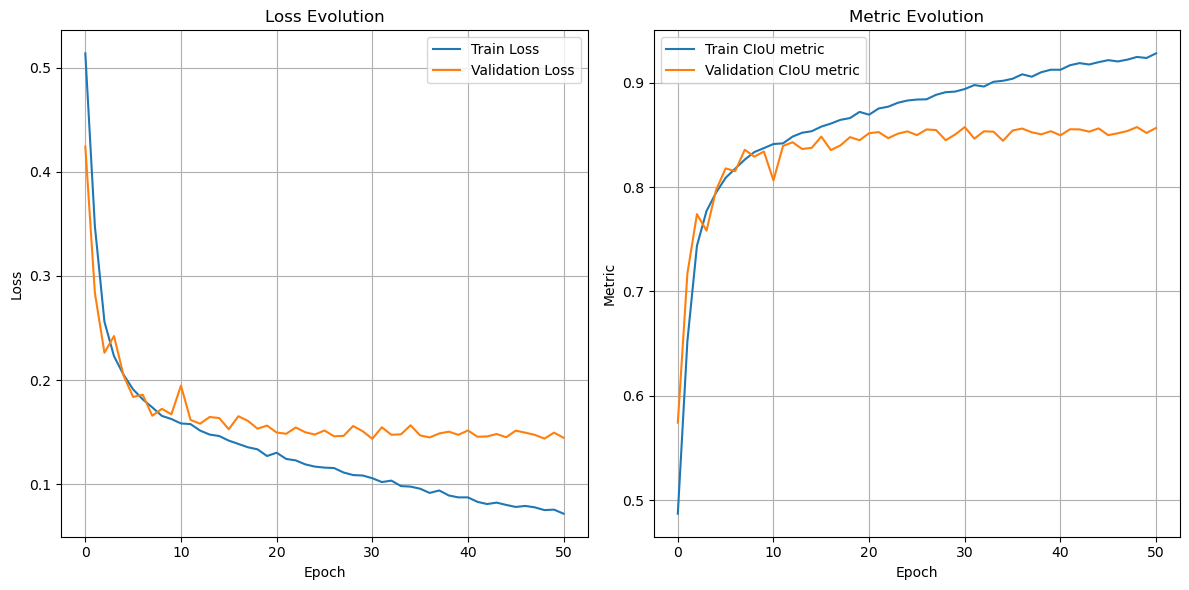

In [10]:
plot_history(history)

In [ ]:
def get_deeper_model(loss: Callable, metric: Callable) -> keras.Model:
    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))

    conv1 = keras.layers.Conv2D(16, 3, padding='same', activation='relu')(_input)
    conv1 = keras.layers.MaxPooling2D()(conv1)

    conv2 = keras.layers.Conv2D(16, 5, padding='same', activation='relu')(_input)
    conv2 = keras.layers.MaxPooling2D()(conv2)

    conv3 = keras.layers.Conv2D(16, 7, padding='same', activation='relu')(_input)
    conv3 = keras.layers.MaxPooling2D()(conv3)

    merged = keras.layers.concatenate([conv1, conv2, conv3])

    conv_module = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(merged)
    conv_module = keras.layers.MaxPooling2D()(conv_module)
    conv_module = keras.layers.Dropout(.2)(conv_module)

    conv_module = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(conv_module)
    conv_module = keras.layers.MaxPooling2D()(conv_module)
    conv_module = keras.layers.Dropout(.2)(conv_module)

    conv_module = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(conv_module)
    conv_module = keras.layers.MaxPooling2D()(conv_module)
    conv_module = keras.layers.Dropout(.2)(conv_module)

    flat = keras.layers.Flatten()(conv_module)

    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dropout(.2)(locator_module)
    locator_module = keras.layers.Dense(256, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history2 = run_model(get_deeper_model, f'roi_detection_iou_9', ciou_loss, ciou_metric)